In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
import scipy.spatial
import subprocess
import pyproj
import pygmsh

In [5]:
from tectosaur.mesh.mesh_gen import make_sphere, make_rect
from tectosaur.mesh.refine import selective_refine, refine_to_size, refine
from tectosaur.util.geometry import unscaled_normals
import tectosaur_topo

In [6]:
import sys
sys.path.append('../common')
from slip_vectors import get_slip_vectors

In [9]:
%config InlineBackend.figure_format = 'retina'

In [10]:
def spherify(m):
    new_pts = r * (m[0] / np.linalg.norm(m[0], axis = 1)[:, np.newaxis])
    #new_tris = scipy.spatial.ConvexHull(new_pts).simplices
    #return (new_pts, new_tris)
    return (new_pts, m[1])

In [11]:
r = 6371000
def manual_sphere():
    orig_surf = make_sphere([0,0,0], r, 10)
    #orig_surf = spherify(refine_to_size(orig_surf, 1000 * 1000 * 1000 * 200)[0])
    orig_surf[1].shape[0]
    focal_point = [r, 0, 0]
    threshold = 1e10
    iters = 0
    max_iters = 0
    inner_ring = 2000000.0
    inner_ring_area = 1000000000.0
    m = orig_surf
    while iters < max_iters:
        iters += 1
        tri_pts = m[0][m[1]]
        tri_centroids = np.mean(tri_pts, axis = 1)
        dist = np.linalg.norm(tri_centroids - focal_point, axis = 1)
        area = np.linalg.norm(unscaled_normals(tri_pts), axis = 1) / 2.0
        print(np.max(area / dist))
        refine = area / (dist ** 0.8) > threshold
        refine = np.where(dist < inner_ring, area > inner_ring_area, refine)
        if np.all(refine == False):
            break
        m = spherify(selective_refine(m, refine))
        print('at iter = ' + str(iters) + ' mesh has ' + str(m[0].shape[0]) + ' pts and ' + str(m[1].shape[0]) + ' tris.')
    return m

def gmsh_sphere():
    code = """
    Point(1) = {0, 0, 0};
    Point(2) = {1, 0, 0};
    Point(3) = {-1, 0, 0};
    Point(4) = {0, 1, 0};
    Point(5) = {0, -1, 0};
    Point(6) = {0, 0, 1};
    Point(7) = {0, 0, -1};
    Circle(1) = {2, 1, 4};
    Circle(2) = {4, 1, 3};
    Circle(3) = {3, 1, 5};
    Circle(4) = {5, 1, 2};
    Circle(5) = {2, 1, 6};
    Circle(6) = {6, 1, 3};
    Circle(7) = {3, 1, 7};
    Circle(8) = {7, 1, 2};
    Circle(9) = {4, 1, 6};
    Circle(10) = {6, 1, 5};
    Circle(11) = {5, 1, 7};
    Circle(12) = {7, 1, 4};
    Line Loop(14) = {2, 7, 12};
    Surface(14) = {14};
    Line Loop(16) = {2, -6, -9};
    Surface(16) = {16};
    Line Loop(18) = {3, -10, 6};
    Surface(18) = {18};
    Line Loop(20) = {3, 11, -7};
    Surface(20) = {20};
    Line Loop(22) = {4, -8, -11};
    Surface(22) = {22};
    Line Loop(24) = {4, 5, 10};
    Surface(24) = {24};
    Line Loop(26) = {1, 9, -5};
    Surface(26) = {26};
    Line Loop(28) = {1, -12, 8};
    Surface(28) = {28};
    Surface Loop(30) = {14, 16, 18, 20, 22, 24, 26, 28};
    Volume(30) = {30};

    lc = 0.3;
    Field[1] = Attractor;
    Field[1].NodesList = {2};

    Field[3] = Threshold;
    Field[3].IField = 1;
    Field[3].LcMin = lc / 10;
    Field[3].LcMax = lc;
    Field[3].DistMin = 0.3;
    Field[3].DistMax = 0.7;

    Field[4] = Min;
    Field[4].FieldsList = {3};

    Background Field = 4;
    """

#     Field[2] = Threshold;
#     Field[2].IField = 1;
#     Field[2].LcMin = lc / 5;
#     Field[2].LcMax = lc;
#     Field[2].DistMin = 0.7;
#     Field[2].DistMax = 1.9;
#     Field[2].Sigmoid = 1;
    geom = pygmsh.built_in.Geometry()
    geom.add_raw_code(code)
    pts, cells, _, _, _ = pygmsh.generate_mesh(geom, dim = 2)
    return r * pts, cells['triangle']

In [12]:
m = gmsh_sphere()

Info    : Running 'gmsh -2 -bin /tmp/tmp6_aicyih.geo -o /tmp/tmps46j1z0q.msh -optimize_lloyd 10' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Tue Oct 10 23:19:20 2017
Info    : Reading '/tmp/tmp6_aicyih.geo'...
Info    : Done reading '/tmp/tmp6_aicyih.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Done meshing 1D (0.024155 s)
Info    : Meshing 2D...
Info    : Meshing surface 14 (Ruled surface, MeshAdapt)
Lloyd: 0 24.122
Lloyd: 1 37.636
Lloyd: 2 42.258
Lloyd: 3 45.942
Lloyd: 4 47.136
Lloyd: 5 48.903
Lloyd

In [13]:
m = spherify(refine(m))
m[1].shape

/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(6872, 3)

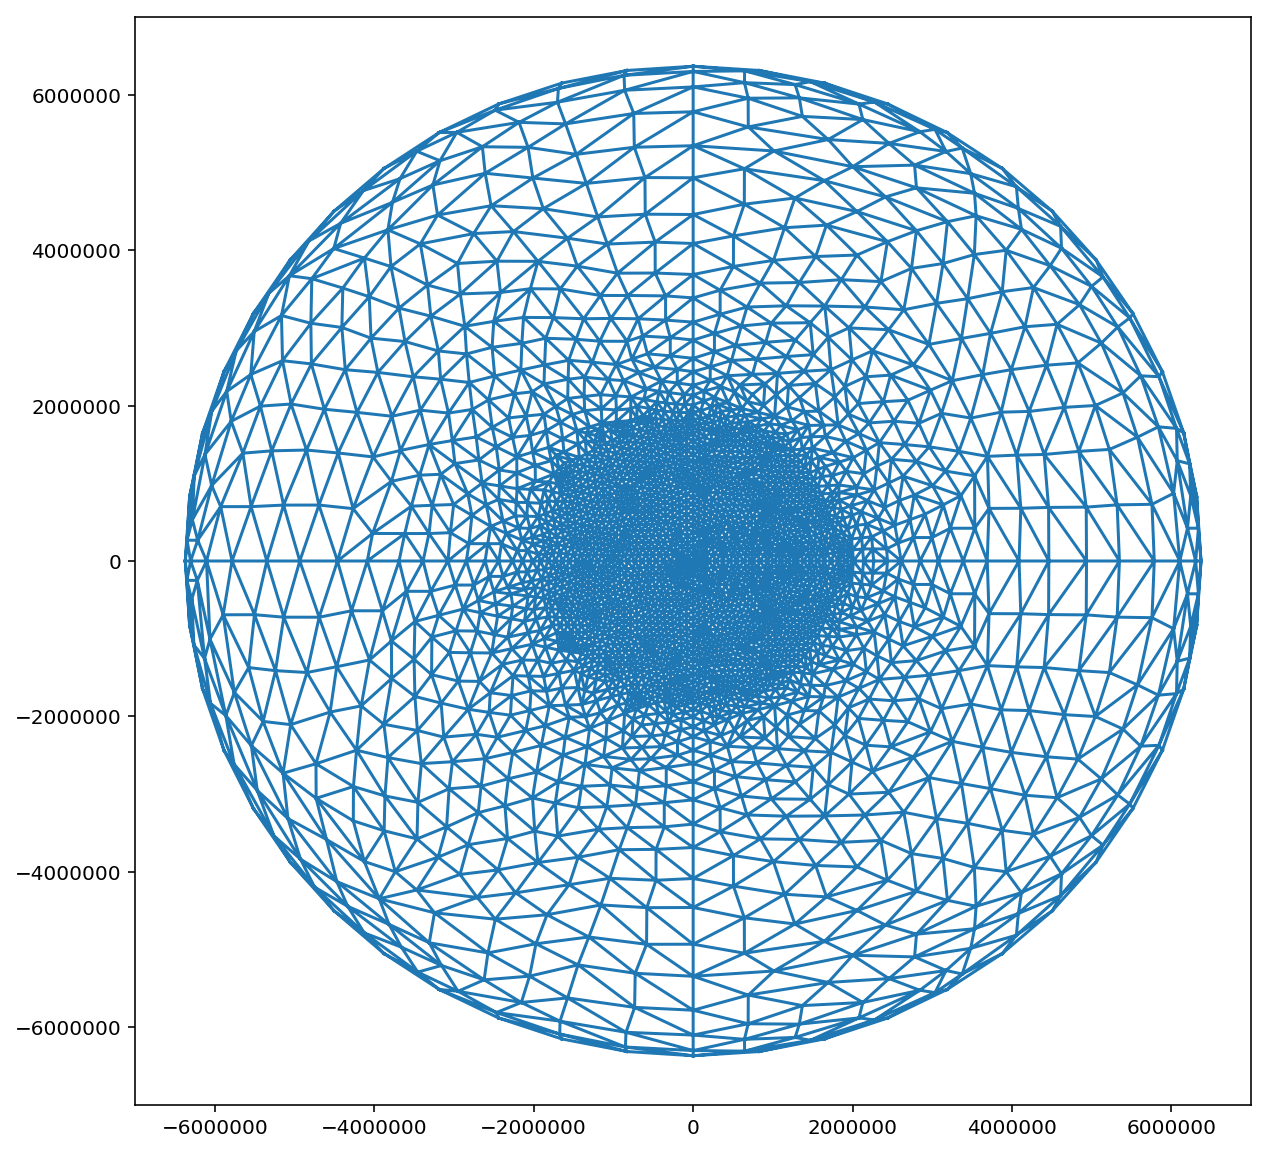

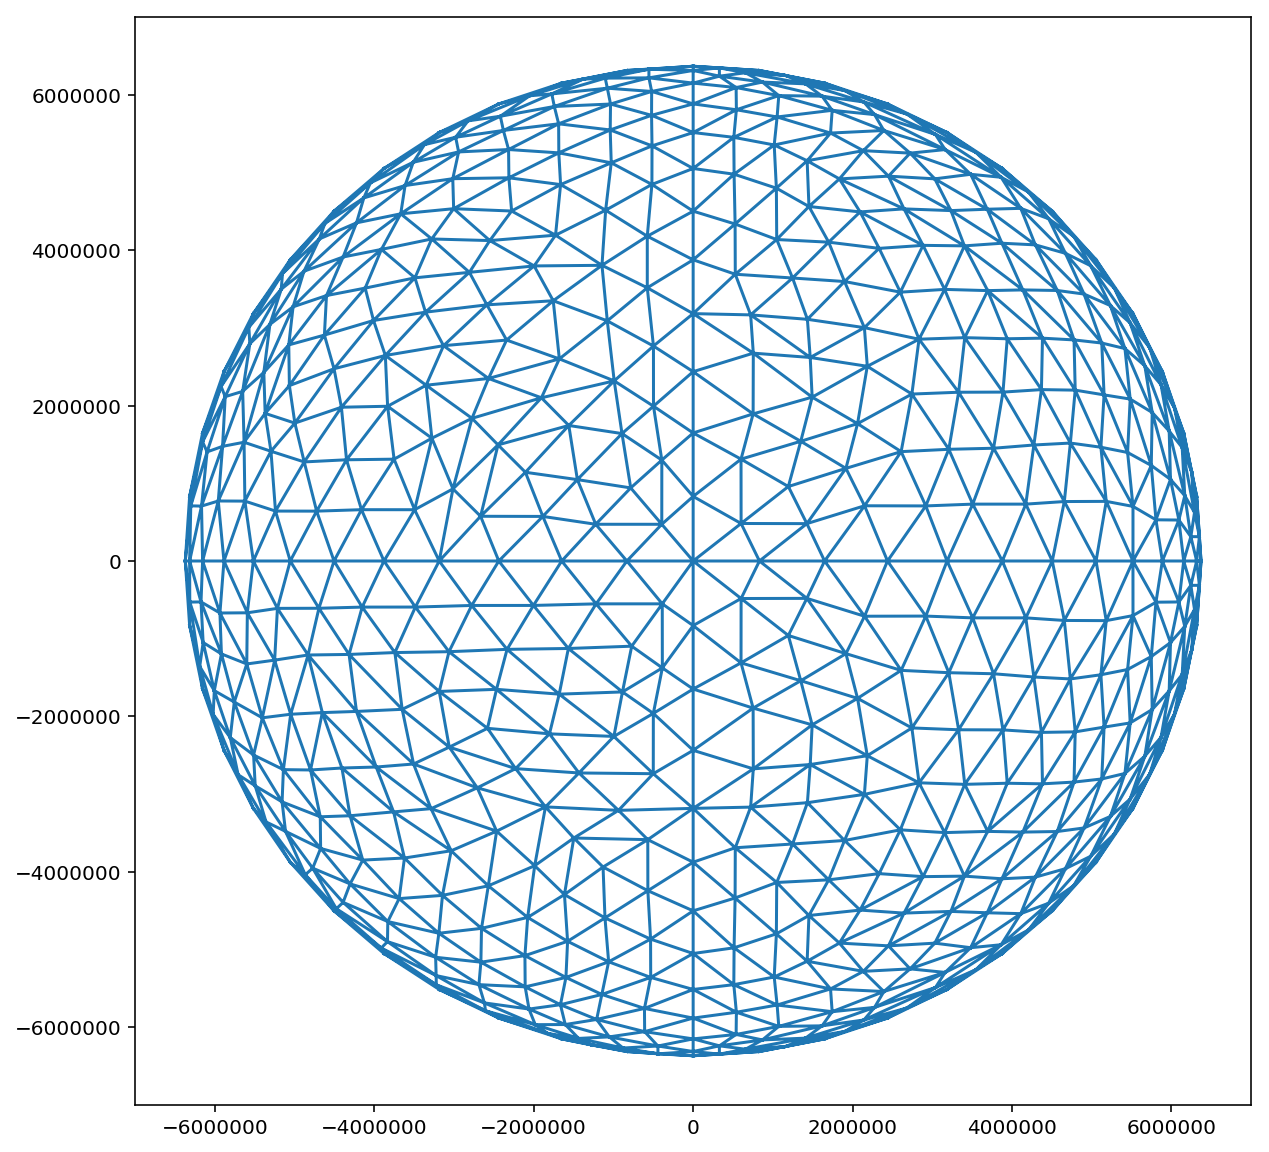

In [14]:
%matplotlib inline
tri_centers = np.mean(m[0][m[1]], axis = 1)
for side in [tri_centers[:,0] > 0, tri_centers[:,0] < 0]:
    plt.figure(figsize = (10,10))
    plt.triplot(m[0][:,1], m[0][:,2], m[1][side,:])
    W = 7000000
    C = [0, 0]
    plt.xlim([C[0] - W, C[0] + W])
    plt.ylim([C[1] - W, C[1] + W])
    plt.show()

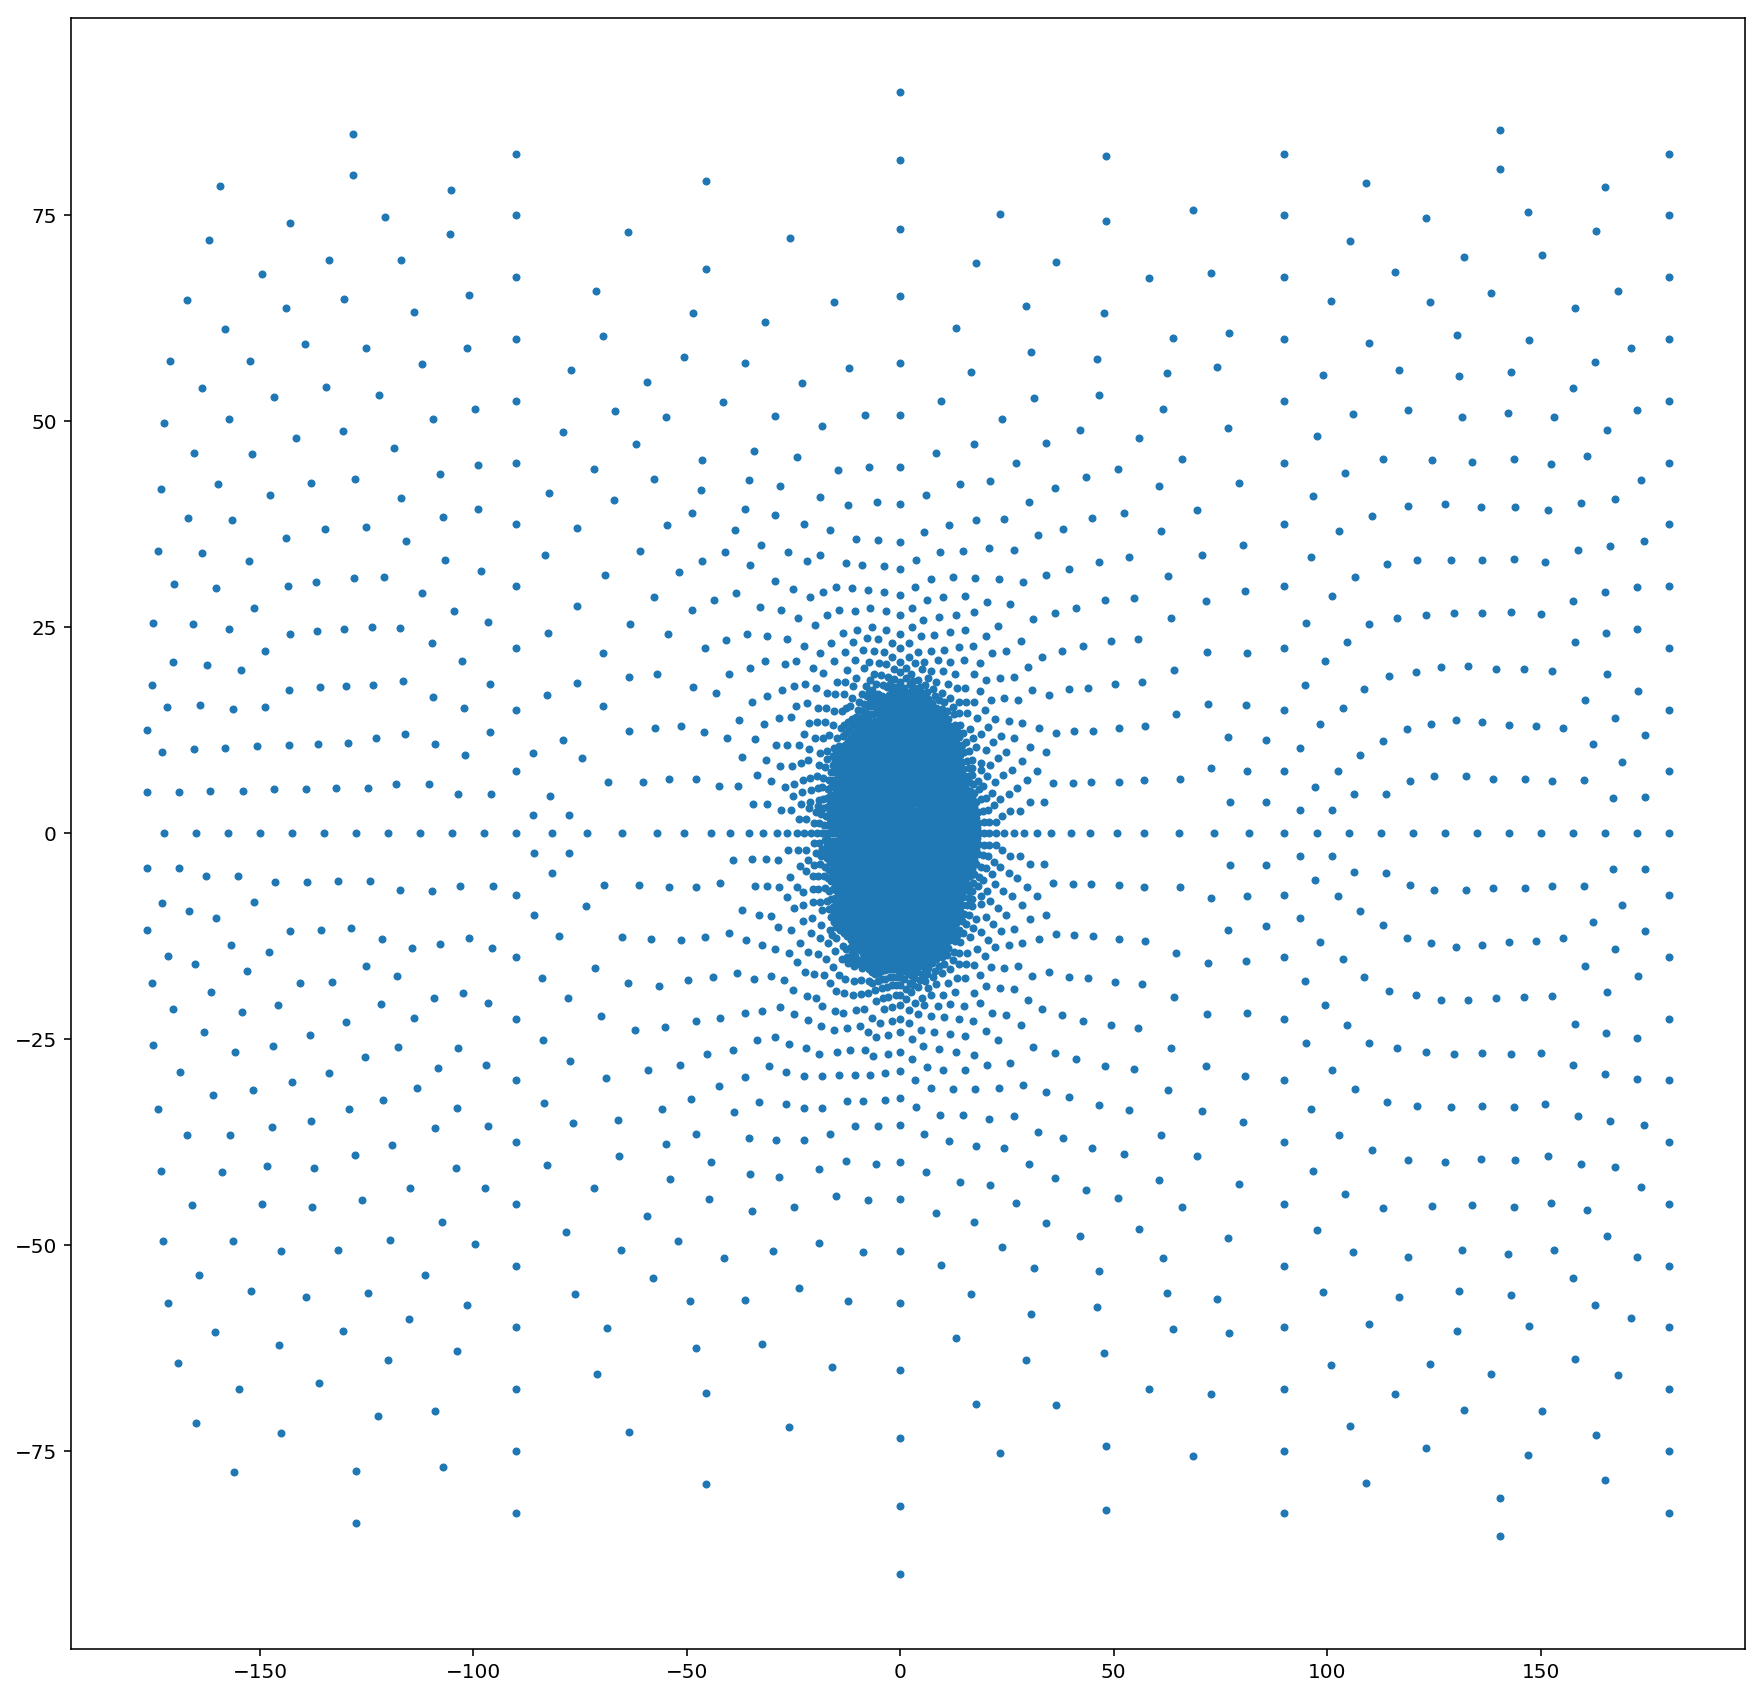

In [15]:
x = m[0][:,0]
y = m[0][:,1]
z = m[0][:,2]
phi = np.arccos(z / r)
latitude = np.rad2deg(phi) - 90
theta = np.arctan2(y, x)
longitude = np.rad2deg(theta)

plt.figure(figsize = (15,15))
plt.plot(longitude, latitude, '.')
plt.show()

In [16]:
wgs84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
proj = pyproj.Proj('+proj=geocent +datum=WGS84 +units=m +no_defs')
x_new,y_new,z_new = pyproj.transform(wgs84, proj, longitude, latitude, 0 * longitude)
projected_pts = np.vstack((x_new,y_new,z_new)).T
m_wgs84 = (projected_pts, m[1])

In [17]:
np.save('refined_sphere_mesh.npy', m_wgs84)

In [18]:
surf = np.load('refined_sphere_mesh.npy')

In [19]:
fault_top_depth = 100 * 1000
fault_bottom_depth = 150 * 1000
fault_length = 1.0
fault_el_size = 10000.0
m_per_deg = 111000
fault_nx = int(fault_length * m_per_deg / fault_el_size)
fault_ny = int((fault_bottom_depth - fault_top_depth) / fault_el_size)

corners = [
    [fault_length / 2, 0, -fault_top_depth],
    [-fault_length / 2, 0, -fault_top_depth],
    [-fault_length / 2, 0, -fault_bottom_depth],
    [fault_length / 2, 0, -fault_bottom_depth]
]
fault = make_rect(fault_nx, fault_ny, corners)
fault[1].shape[0]

80

In [20]:
wgs84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
proj = pyproj.Proj('+proj=geocent +datum=WGS84 +units=m +no_defs')
x_new,y_new,z_new = pyproj.transform(wgs84, proj, fault[0][:,0], fault[0][:,1], fault[0][:,2])
projected_pts = np.vstack((x_new,y_new,z_new)).T
fault_projected = (projected_pts, fault[1])

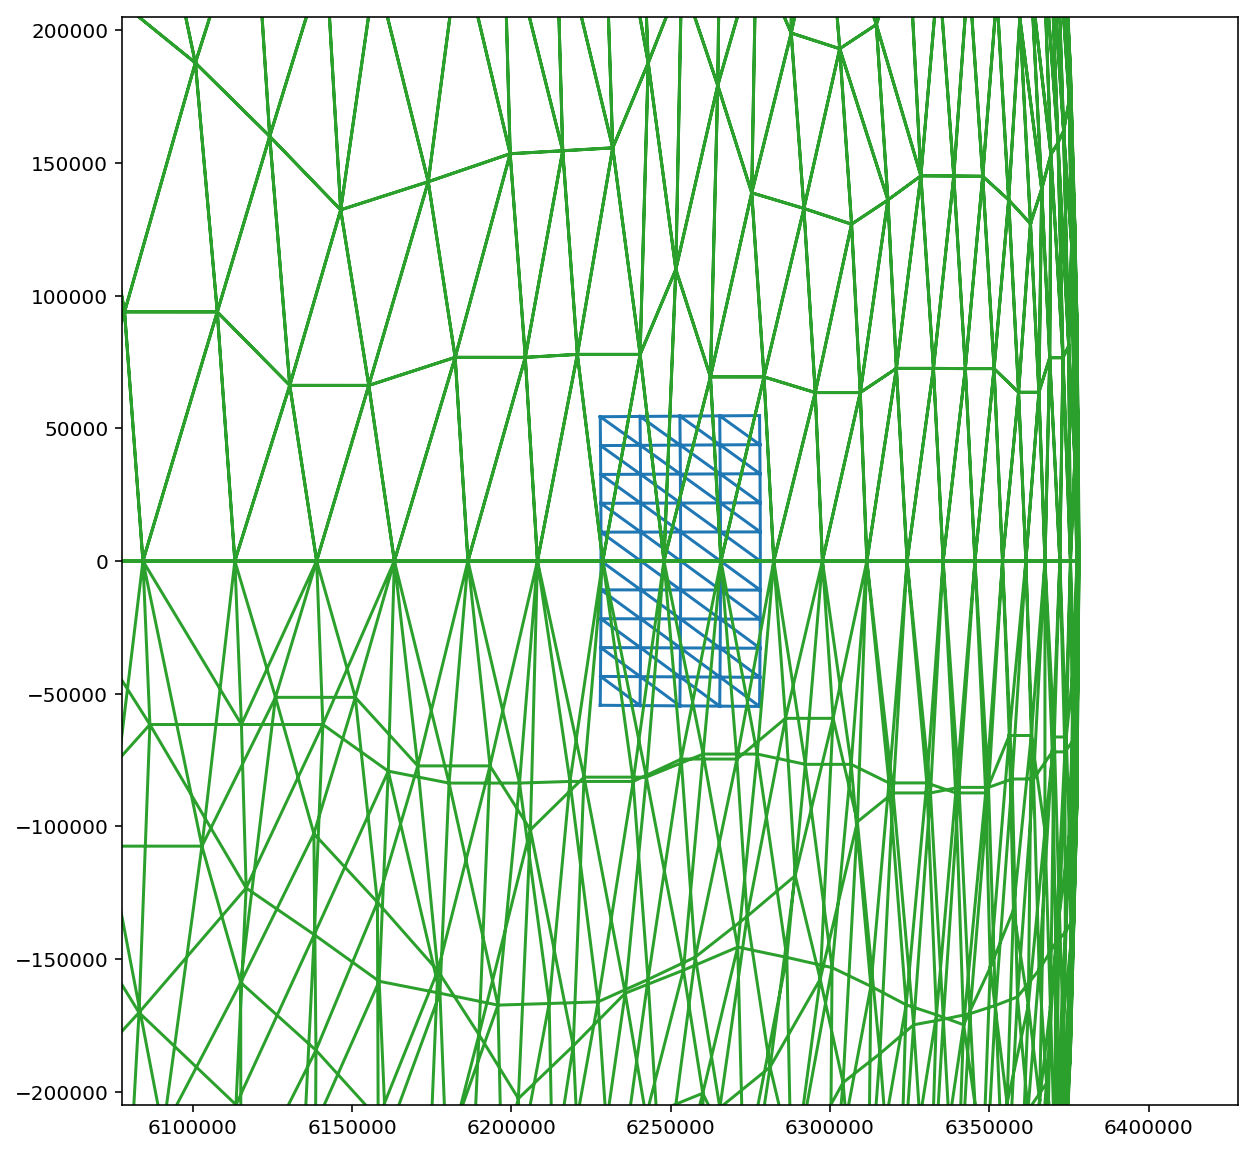

In [21]:
%matplotlib inline
plt.figure(figsize = (10,10))
plt.triplot(fault_projected[0][:,0], fault_projected[0][:,1], fault_projected[1])
plt.triplot(surf[0][:,0], surf[0][:,1], surf[1])
expand = 150000
plt.xlim([np.min(fault_projected[0][:,0]) - expand, np.max(fault_projected[0][:,0]) + expand])
plt.ylim([np.min(fault_projected[0][:,1]) - expand, np.max(fault_projected[0][:,1]) + expand])
plt.show()

In [22]:
v1,v2 = get_slip_vectors(projected_pts[fault[1][0,:]])
print(v1,v2)
fault_slip = np.array([[0, 1, 0]] * 3 * fault[1].shape[0]).flatten()
#project fault and fault slip

[-0.  1.  0.] [-1. -0.  0.]


In [23]:
np.save('solve_input.npy', [surf, fault_projected, fault_slip])

In [1]:
# When using a locally refined sphere mesh, this fails to converge properly...
# I think a good next step might be to use a dense matrix/direct solver to check
# that the matrix is well-conditioned. I suspect the problem is in the constraints
# but I'm not so sure where exactly...
# Another possiblity is that the local refinement inherently creates a poorly conditioned
# matrix. This actually seems likely. 

# What's up with the squigglyness of the resulting field???! Is it a result of the poor spatial scaling?
# Another possiblity is that variation in mesh size causes problems. 
# This is testable in a planar setting with some mesh density variations!

# The simplest possibility might be that the mesh resolution is just too low.
# Actually, it seems like the scipy ConvexHull thing is causing problems!
import numpy as np
import tectosaur_topo
surf, fault_projected, fault_slip = np.load('solve_input.npy')
surf_pts, surf_disp, soln = tectosaur_topo.solve_topo(surf, fault_projected, fault_slip, 1.0, 0.25)
np.save('sphere_result.npy', [surf_pts, surf_disp, soln])
surf_pts, surf_disp, soln = np.load('sphere_result.npy')

2017-10-10 23:31:55,589 - tectosaur.util.gpu - DEBUG - start compiling nearfield/nearfield.cl
2017-10-10 23:31:56,742 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 0
2017-10-10 23:31:56,984 - tectosaur.util.gpu - DEBUG - compile took 1.3945553302764893
2017-10-10 23:31:57,001 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 1.411806344985962
2017-10-10 23:31:57,008 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.005513191223144531
2017-10-10 23:31:57,060 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.05083918571472168
2017-10-10 23:31:57,061 - tectosaur.util.gpu - DEBUG - start compiling nearfield/table_lookup.cl
2017-10-10 23:31:57,336 - tectosaur.util.gpu - DEBUG - compile took 0.2753772735595703
2017-10-10 23:31:57,355 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.2944977283477783
2017-10-10 23:31:57,376 - tectosaur.nearfield.table_lookup - DEBUG - coinciden

2017-10-10 23:32:01,739 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04177069664001465
2017-10-10 23:32:01,741 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006737709045410156
2017-10-10 23:32:01,742 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04643654823303223
2017-10-10 23:32:01,744 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.25258612632751465
2017-10-10 23:32:01,745 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002689361572265625
2017-10-10 23:32:01,746 - tectosaur_topo.solve - DEBUG - setup linear operator took 0.5744061470031738
2017-10-10 23:32:01,747 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-10-10 23:32:01,748 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000209808349609375
2017-10-10 23:32:01,956 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2071681022644043
2017-10-10 23:32:01,959 - tectosaur.ops.

2017-10-10 23:32:03,177 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.151139497756958
2017-10-10 23:32:03,180 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012483596801757812
2017-10-10 23:32:03,181 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004782676696777344
2017-10-10 23:32:03,220 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03650808334350586
2017-10-10 23:32:03,221 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037871599197387695
2017-10-10 23:32:03,223 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008144378662109375
2017-10-10 23:32:03,224 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04335904121398926
2017-10-10 23:32:03,226 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006732940673828125
2017-10-10 23:32:03,227 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04811525344848633
2017-1

2017-10-10 23:32:04,574 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007593631744384766
2017-10-10 23:32:04,575 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.047191619873046875
2017-10-10 23:32:04,577 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.2918272018432617
2017-10-10 23:32:04,579 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00035881996154785156
2017-10-10 23:32:04,579 - tectosaur_topo.solve - DEBUG - residual: 0.7823473692596377
2017-10-10 23:32:04,581 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-10-10 23:32:04,582 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00020647048950195312
2017-10-10 23:32:04,817 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.23458552360534668
2017-10-10 23:32:04,821 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0015461444854736328
2017-10-10 23:32:04,823 - tectosaur.ops.sp

2017-10-10 23:32:06,052 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.17302489280700684
2017-10-10 23:32:06,055 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014111995697021484
2017-10-10 23:32:06,056 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005130767822265625
2017-10-10 23:32:06,094 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036479949951171875
2017-10-10 23:32:06,095 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03784990310668945
2017-10-10 23:32:06,097 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005207061767578125
2017-10-10 23:32:06,098 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04209113121032715
2017-10-10 23:32:06,100 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006718635559082031
2017-10-10 23:32:06,101 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04748344421386719
2017

2017-10-10 23:32:07,249 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006859302520751953
2017-10-10 23:32:07,250 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.047377586364746094
2017-10-10 23:32:07,252 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.2233409881591797
2017-10-10 23:32:07,253 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003292560577392578
2017-10-10 23:32:07,254 - tectosaur_topo.solve - DEBUG - residual: 0.2116777747807824
2017-10-10 23:32:07,256 - tectosaur_topo.solve - DEBUG - iteration # 25
2017-10-10 23:32:07,257 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00023508071899414062
2017-10-10 23:32:07,430 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1725482940673828
2017-10-10 23:32:07,433 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001428365707397461
2017-10-10 23:32:07,435 - tectosaur.ops.spars

2017-10-10 23:32:08,582 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.17276215553283691
2017-10-10 23:32:08,585 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014615058898925781
2017-10-10 23:32:08,587 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005135536193847656
2017-10-10 23:32:08,625 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036525726318359375
2017-10-10 23:32:08,626 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.038091182708740234
2017-10-10 23:32:08,628 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006384849548339844
2017-10-10 23:32:08,629 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04269123077392578
2017-10-10 23:32:08,631 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006394386291503906
2017-10-10 23:32:08,632 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.048095703125
2017-10-

2017-10-10 23:32:09,848 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010709762573242188
2017-10-10 23:32:09,849 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.047898054122924805
2017-10-10 23:32:09,852 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.27112364768981934
2017-10-10 23:32:09,853 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000568389892578125
2017-10-10 23:32:09,854 - tectosaur_topo.solve - DEBUG - residual: 0.06713286856973172
2017-10-10 23:32:09,856 - tectosaur_topo.solve - DEBUG - iteration # 36
2017-10-10 23:32:09,858 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00023221969604492188
2017-10-10 23:32:10,054 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.19490981101989746
2017-10-10 23:32:10,057 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0018699169158935547
2017-10-10 23:32:10,058 - tectosaur.ops.sp

2017-10-10 23:32:11,209 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.15932178497314453
2017-10-10 23:32:11,212 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001268625259399414
2017-10-10 23:32:11,214 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00048422813415527344
2017-10-10 23:32:11,251 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036455631256103516
2017-10-10 23:32:11,252 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03777813911437988
2017-10-10 23:32:11,254 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005223751068115234
2017-10-10 23:32:11,255 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04198861122131348
2017-10-10 23:32:11,257 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009133815765380859
2017-10-10 23:32:11,258 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04734086990356445
2017

2017-10-10 23:32:12,435 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.000652313232421875
2017-10-10 23:32:12,437 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04770398139953613
2017-10-10 23:32:12,439 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.295001745223999
2017-10-10 23:32:12,440 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002200603485107422
2017-10-10 23:32:12,441 - tectosaur_topo.solve - DEBUG - residual: 0.031466021591725374
2017-10-10 23:32:12,444 - tectosaur_topo.solve - DEBUG - iteration # 47
2017-10-10 23:32:12,445 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00014901161193847656
2017-10-10 23:32:12,652 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.20640182495117188
2017-10-10 23:32:12,655 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009691715240478516
2017-10-10 23:32:12,656 - tectosaur.ops.spar

2017-10-10 23:32:13,779 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.15903568267822266
2017-10-10 23:32:13,781 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008664131164550781
2017-10-10 23:32:13,782 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004417896270751953
2017-10-10 23:32:13,820 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03656768798828125
2017-10-10 23:32:13,822 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03826260566711426
2017-10-10 23:32:13,824 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010609626770019531
2017-10-10 23:32:13,825 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04316306114196777
2017-10-10 23:32:13,828 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013108253479003906
2017-10-10 23:32:13,828 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04844236373901367
2017-

2017-10-10 23:32:15,187 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006475448608398438
2017-10-10 23:32:15,188 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.046356201171875
2017-10-10 23:32:15,190 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.255875825881958
2017-10-10 23:32:15,191 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002655982971191406
2017-10-10 23:32:15,192 - tectosaur_topo.solve - DEBUG - residual: 0.023155019480259404
2017-10-10 23:32:15,194 - tectosaur_topo.solve - DEBUG - iteration # 58
2017-10-10 23:32:15,195 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00017142295837402344
2017-10-10 23:32:15,362 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.16610932350158691
2017-10-10 23:32:15,365 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008490085601806641
2017-10-10 23:32:15,366 - tectosaur.ops.spars

2017-10-10 23:32:16,555 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1677565574645996
2017-10-10 23:32:16,558 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008378028869628906
2017-10-10 23:32:16,559 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000492095947265625
2017-10-10 23:32:16,597 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036444664001464844
2017-10-10 23:32:16,598 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037613868713378906
2017-10-10 23:32:16,599 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005164146423339844
2017-10-10 23:32:16,600 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.041667938232421875
2017-10-10 23:32:16,602 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006225109100341797
2017-10-10 23:32:16,603 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04593348503112793
2017

2017-10-10 23:32:17,864 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006885528564453125
2017-10-10 23:32:17,865 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0471038818359375
2017-10-10 23:32:17,867 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.24542570114135742
2017-10-10 23:32:17,868 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002560615539550781
2017-10-10 23:32:17,869 - tectosaur_topo.solve - DEBUG - residual: 0.017304798889599505
2017-10-10 23:32:17,872 - tectosaur_topo.solve - DEBUG - iteration # 69
2017-10-10 23:32:17,873 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002117156982421875
2017-10-10 23:32:18,081 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.20697546005249023
2017-10-10 23:32:18,084 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009043216705322266
2017-10-10 23:32:18,085 - tectosaur.ops.spa

2017-10-10 23:32:19,384 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.15544986724853516
2017-10-10 23:32:19,387 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009999275207519531
2017-10-10 23:32:19,389 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006995201110839844
2017-10-10 23:32:19,427 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03697991371154785
2017-10-10 23:32:19,428 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03840446472167969
2017-10-10 23:32:19,430 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005788803100585938
2017-10-10 23:32:19,431 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0428004264831543
2017-10-10 23:32:19,432 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006818771362304688
2017-10-10 23:32:19,433 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04752492904663086
2017-1

2017-10-10 23:32:20,699 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006356239318847656
2017-10-10 23:32:20,700 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.045792341232299805
2017-10-10 23:32:20,701 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.23206424713134766
2017-10-10 23:32:20,703 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003211498260498047
2017-10-10 23:32:20,703 - tectosaur_topo.solve - DEBUG - residual: 0.009942427187110421
2017-10-10 23:32:20,706 - tectosaur_topo.solve - DEBUG - iteration # 80
2017-10-10 23:32:20,707 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00019407272338867188
2017-10-10 23:32:20,891 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.18334650993347168
2017-10-10 23:32:20,894 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012354850769042969
2017-10-10 23:32:20,895 - tectosaur.ops.

2017-10-10 23:32:22,296 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2277507781982422
2017-10-10 23:32:22,300 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013391971588134766
2017-10-10 23:32:22,301 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005269050598144531
2017-10-10 23:32:22,339 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03669166564941406
2017-10-10 23:32:22,341 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.038526296615600586
2017-10-10 23:32:22,344 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.001306295394897461
2017-10-10 23:32:22,345 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04404807090759277
2017-10-10 23:32:22,348 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0016632080078125
2017-10-10 23:32:22,349 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.050484657287597656
2017-10-

2017-10-10 23:32:23,807 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006756782531738281
2017-10-10 23:32:23,808 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04682302474975586
2017-10-10 23:32:23,810 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.32412004470825195
2017-10-10 23:32:23,811 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002853870391845703
2017-10-10 23:32:23,812 - tectosaur_topo.solve - DEBUG - residual: 0.00673139525267338
2017-10-10 23:32:23,815 - tectosaur_topo.solve - DEBUG - iteration # 91
2017-10-10 23:32:23,816 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00015282630920410156
2017-10-10 23:32:24,039 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.22233033180236816
2017-10-10 23:32:24,043 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014278888702392578
2017-10-10 23:32:24,045 - tectosaur.ops.sp

2017-10-10 23:32:25,654 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.31070590019226074
2017-10-10 23:32:25,659 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0017325878143310547
2017-10-10 23:32:25,661 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004999637603759766
2017-10-10 23:32:25,700 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.037592172622680664
2017-10-10 23:32:25,702 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03922271728515625
2017-10-10 23:32:25,703 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005223751068115234
2017-10-10 23:32:25,704 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04384970664978027
2017-10-10 23:32:25,706 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009915828704833984
2017-10-10 23:32:25,707 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.049875497817993164
201

2017-10-10 23:32:26,941 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005886554718017578
2017-10-10 23:32:26,942 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04648184776306152
2017-10-10 23:32:26,943 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.2102980613708496
2017-10-10 23:32:26,945 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002460479736328125
2017-10-10 23:32:26,947 - tectosaur_topo.solve - DEBUG - residual: 0.0032137011158707668
2017-10-10 23:32:26,953 - tectosaur_topo.solve - DEBUG - iteration # 102
2017-10-10 23:32:26,954 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002090930938720703
2017-10-10 23:32:27,087 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1317884922027588
2017-10-10 23:32:27,090 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008065700531005859
2017-10-10 23:32:27,091 - tectosaur.ops.sp

2017-10-10 23:32:28,053 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13063693046569824
2017-10-10 23:32:28,055 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007455348968505859
2017-10-10 23:32:28,056 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004448890686035156
2017-10-10 23:32:28,094 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036330223083496094
2017-10-10 23:32:28,095 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03758549690246582
2017-10-10 23:32:28,097 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005915164947509766
2017-10-10 23:32:28,098 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.041950225830078125
2017-10-10 23:32:28,100 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006682872772216797
2017-10-10 23:32:28,101 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04661393165588379
201

2017-10-10 23:32:29,065 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006177425384521484
2017-10-10 23:32:29,066 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0466005802154541
2017-10-10 23:32:29,068 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.18062281608581543
2017-10-10 23:32:29,069 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00018453598022460938
2017-10-10 23:32:29,070 - tectosaur_topo.solve - DEBUG - residual: 0.0017627994081546457
2017-10-10 23:32:29,073 - tectosaur_topo.solve - DEBUG - iteration # 113
2017-10-10 23:32:29,075 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0008687973022460938
2017-10-10 23:32:29,206 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1301720142364502
2017-10-10 23:32:29,208 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007321834564208984
2017-10-10 23:32:29,209 - tectosaur.ops.s

2017-10-10 23:32:30,151 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13321161270141602
2017-10-10 23:32:30,154 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008106231689453125
2017-10-10 23:32:30,156 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004379749298095703
2017-10-10 23:32:30,194 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036582231521606445
2017-10-10 23:32:30,195 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03808999061584473
2017-10-10 23:32:30,197 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005037784576416016
2017-10-10 23:32:30,198 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.042577505111694336
2017-10-10 23:32:30,200 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007107257843017578
2017-10-10 23:32:30,201 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04730963706970215
201

2017-10-10 23:32:31,160 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006017684936523438
2017-10-10 23:32:31,161 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04613995552062988
2017-10-10 23:32:31,163 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.18033075332641602
2017-10-10 23:32:31,164 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00017333030700683594
2017-10-10 23:32:31,165 - tectosaur_topo.solve - DEBUG - residual: 0.000959482901915141
2017-10-10 23:32:31,169 - tectosaur_topo.solve - DEBUG - iteration # 124
2017-10-10 23:32:31,170 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00018405914306640625
2017-10-10 23:32:31,302 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13118863105773926
2017-10-10 23:32:31,304 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007405281066894531
2017-10-10 23:32:31,306 - tectosaur.ops

2017-10-10 23:32:32,248 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13220524787902832
2017-10-10 23:32:32,250 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000736236572265625
2017-10-10 23:32:32,252 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004360675811767578
2017-10-10 23:32:32,289 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03630685806274414
2017-10-10 23:32:32,290 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03761649131774902
2017-10-10 23:32:32,292 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004961490631103516
2017-10-10 23:32:32,293 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04195570945739746
2017-10-10 23:32:32,295 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005371570587158203
2017-10-10 23:32:32,296 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04642367362976074
2017-1

2017-10-10 23:32:33,244 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006096363067626953
2017-10-10 23:32:33,245 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04653048515319824
2017-10-10 23:32:33,246 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.1804959774017334
2017-10-10 23:32:33,248 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00018167495727539062
2017-10-10 23:32:33,249 - tectosaur_topo.solve - DEBUG - residual: 0.0004666954554636347
2017-10-10 23:32:33,252 - tectosaur_topo.solve - DEBUG - iteration # 135
2017-10-10 23:32:33,253 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002722740173339844
2017-10-10 23:32:33,385 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1303708553314209
2017-10-10 23:32:33,387 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007562637329101562
2017-10-10 23:32:33,388 - tectosaur.ops.s

2017-10-10 23:32:34,334 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1332840919494629
2017-10-10 23:32:34,336 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007297992706298828
2017-10-10 23:32:34,338 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00043964385986328125
2017-10-10 23:32:34,376 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03632688522338867
2017-10-10 23:32:34,377 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037714481353759766
2017-10-10 23:32:34,378 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00043392181396484375
2017-10-10 23:32:34,380 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04194760322570801
2017-10-10 23:32:34,381 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006232261657714844
2017-10-10 23:32:34,382 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04655647277832031
201

2017-10-10 23:32:35,356 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009121894836425781
2017-10-10 23:32:35,357 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04793047904968262
2017-10-10 23:32:35,359 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.1970829963684082
2017-10-10 23:32:35,360 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001888275146484375
2017-10-10 23:32:35,361 - tectosaur_topo.solve - DEBUG - residual: 0.00027184440415259315
2017-10-10 23:32:35,364 - tectosaur_topo.solve - DEBUG - iteration # 146
2017-10-10 23:32:35,366 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003619194030761719
2017-10-10 23:32:35,497 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13062453269958496
2017-10-10 23:32:35,499 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007419586181640625
2017-10-10 23:32:35,501 - tectosaur.ops.

2017-10-10 23:32:36,471 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13035798072814941
2017-10-10 23:32:36,473 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000732421875
2017-10-10 23:32:36,474 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00044155120849609375
2017-10-10 23:32:36,512 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03630566596984863
2017-10-10 23:32:36,513 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037641286849975586
2017-10-10 23:32:36,514 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004706382751464844
2017-10-10 23:32:36,516 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04200625419616699
2017-10-10 23:32:36,517 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.000621795654296875
2017-10-10 23:32:36,518 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04648184776306152
2017-10-10 

2017-10-10 23:32:37,461 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005660057067871094
2017-10-10 23:32:37,462 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.046500205993652344
2017-10-10 23:32:37,464 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.18037724494934082
2017-10-10 23:32:37,465 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000186920166015625
2017-10-10 23:32:37,467 - tectosaur_topo.solve - DEBUG - residual: 0.0001969411454541806
2017-10-10 23:32:37,470 - tectosaur_topo.solve - DEBUG - iteration # 157
2017-10-10 23:32:37,472 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00042891502380371094
2017-10-10 23:32:37,605 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13159918785095215
2017-10-10 23:32:37,607 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007927417755126953
2017-10-10 23:32:37,609 - tectosaur.ops

2017-10-10 23:32:38,554 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13111543655395508
2017-10-10 23:32:38,556 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007500648498535156
2017-10-10 23:32:38,557 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00044035911560058594
2017-10-10 23:32:38,595 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03633379936218262
2017-10-10 23:32:38,596 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03759360313415527
2017-10-10 23:32:38,598 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005078315734863281
2017-10-10 23:32:38,599 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04175066947937012
2017-10-10 23:32:38,600 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006148815155029297
2017-10-10 23:32:38,601 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04607963562011719
2017

2017-10-10 23:32:39,551 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006847381591796875
2017-10-10 23:32:39,552 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04710030555725098
2017-10-10 23:32:39,554 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.18477773666381836
2017-10-10 23:32:39,555 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00019240379333496094
2017-10-10 23:32:39,557 - tectosaur_topo.solve - DEBUG - residual: 0.00015756640471331
2017-10-10 23:32:39,560 - tectosaur_topo.solve - DEBUG - iteration # 168
2017-10-10 23:32:39,563 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0008423328399658203
2017-10-10 23:32:39,696 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1318814754486084
2017-10-10 23:32:39,698 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007677078247070312
2017-10-10 23:32:39,700 - tectosaur.ops.sp

2017-10-10 23:32:40,641 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13095498085021973
2017-10-10 23:32:40,643 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007746219635009766
2017-10-10 23:32:40,644 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00043487548828125
2017-10-10 23:32:40,682 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03630471229553223
2017-10-10 23:32:40,683 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037564992904663086
2017-10-10 23:32:40,685 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005259513854980469
2017-10-10 23:32:40,686 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04189038276672363
2017-10-10 23:32:40,688 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006046295166015625
2017-10-10 23:32:40,689 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04658675193786621
2017-1

2017-10-10 23:32:41,644 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006098747253417969
2017-10-10 23:32:41,645 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04624485969543457
2017-10-10 23:32:41,646 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.17902183532714844
2017-10-10 23:32:41,647 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00017881393432617188
2017-10-10 23:32:41,649 - tectosaur_topo.solve - DEBUG - residual: 8.139771570812447e-05
2017-10-10 23:32:41,654 - tectosaur_topo.solve - DEBUG - iteration # 179
2017-10-10 23:32:41,655 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0007469654083251953
2017-10-10 23:32:41,789 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1323227882385254
2017-10-10 23:32:41,791 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007319450378417969
2017-10-10 23:32:41,792 - tectosaur.ops.

2017-10-10 23:32:42,734 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13008809089660645
2017-10-10 23:32:42,736 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007305145263671875
2017-10-10 23:32:42,737 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004425048828125
2017-10-10 23:32:42,775 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036319732666015625
2017-10-10 23:32:42,776 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037634849548339844
2017-10-10 23:32:42,777 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005066394805908203
2017-10-10 23:32:42,778 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04159140586853027
2017-10-10 23:32:42,780 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006039142608642578
2017-10-10 23:32:42,781 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.046141862869262695
2017-

2017-10-10 23:32:43,726 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006136894226074219
2017-10-10 23:32:43,727 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.046605825424194336
2017-10-10 23:32:43,729 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.18038535118103027
2017-10-10 23:32:43,730 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001804828643798828
2017-10-10 23:32:43,731 - tectosaur_topo.solve - DEBUG - residual: 1.7480723373420248e-05
2017-10-10 23:32:43,735 - tectosaur_topo.solve - DEBUG - iteration # 190
2017-10-10 23:32:43,737 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002002716064453125
2017-10-10 23:32:43,869 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13096308708190918
2017-10-10 23:32:43,871 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007541179656982422
2017-10-10 23:32:43,872 - tectosaur.op

2017-10-10 23:32:44,817 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13024187088012695
2017-10-10 23:32:44,819 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007331371307373047
2017-10-10 23:32:44,820 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00045490264892578125
2017-10-10 23:32:44,858 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03641939163208008
2017-10-10 23:32:44,860 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03866887092590332
2017-10-10 23:32:44,862 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005095005035400391
2017-10-10 23:32:44,863 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04275250434875488
2017-10-10 23:32:44,864 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006906986236572266
2017-10-10 23:32:44,865 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.047251224517822266
201

2017-10-10 23:32:45,811 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005290508270263672
2017-10-10 23:32:45,812 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04603886604309082
2017-10-10 23:32:45,813 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.17981266975402832
2017-10-10 23:32:45,815 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00025582313537597656
2017-10-10 23:32:45,816 - tectosaur_topo.solve - DEBUG - residual: 1.6237822698307835e-05
2017-10-10 23:32:45,819 - tectosaur_topo.solve - DEBUG - iteration # 201
2017-10-10 23:32:45,820 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001475811004638672
2017-10-10 23:32:45,952 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13023781776428223
2017-10-10 23:32:45,954 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007431507110595703
2017-10-10 23:32:45,955 - tectosaur.op

2017-10-10 23:32:46,900 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13063836097717285
2017-10-10 23:32:46,903 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007655620574951172
2017-10-10 23:32:46,904 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00044727325439453125
2017-10-10 23:32:46,942 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.036310434341430664
2017-10-10 23:32:46,943 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0375666618347168
2017-10-10 23:32:46,944 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005002021789550781
2017-10-10 23:32:46,945 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.041719675064086914
2017-10-10 23:32:46,947 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006070137023925781
2017-10-10 23:32:46,948 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0460817813873291
2017

2017-10-10 23:32:47,901 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006375312805175781
2017-10-10 23:32:47,902 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04731440544128418
2017-10-10 23:32:47,904 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.18335270881652832
2017-10-10 23:32:47,906 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0009891986846923828
2017-10-10 23:32:47,907 - tectosaur_topo.solve - DEBUG - residual: 2.457935524777855e-06
2017-10-10 23:32:47,911 - tectosaur_topo.solve - DEBUG - iteration # 212
2017-10-10 23:32:47,913 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001399517059326172
2017-10-10 23:32:48,064 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.14930391311645508
2017-10-10 23:32:48,066 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009319782257080078
2017-10-10 23:32:48,068 - tectosaur.ops.

2017-10-10 23:32:49,025 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13009333610534668
2017-10-10 23:32:49,027 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007429122924804688
2017-10-10 23:32:49,029 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00043463706970214844
2017-10-10 23:32:49,067 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03638911247253418
2017-10-10 23:32:49,068 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03770852088928223
2017-10-10 23:32:49,069 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00047206878662109375
2017-10-10 23:32:49,070 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.04188060760498047
2017-10-10 23:32:49,072 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006411075592041016
2017-10-10 23:32:49,073 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04625868797302246
201

2017-10-10 23:32:50,050 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006175041198730469
2017-10-10 23:32:50,051 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0465235710144043
2017-10-10 23:32:50,053 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.17972946166992188
2017-10-10 23:32:50,054 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00016450881958007812
2017-10-10 23:32:50,055 - tectosaur_topo.solve - DEBUG - residual: 6.762710935675283e-08
2017-10-10 23:32:50,059 - tectosaur_topo.solve - DEBUG - iteration # 223
2017-10-10 23:32:50,061 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00023245811462402344
2017-10-10 23:32:50,211 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.14844965934753418
2017-10-10 23:32:50,213 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008437633514404297
2017-10-10 23:32:50,215 - tectosaur.ops

2017-10-10 23:32:51,158 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13040423393249512
2017-10-10 23:32:51,160 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007350444793701172
2017-10-10 23:32:51,162 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006353855133056641
2017-10-10 23:32:51,200 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03632760047912598
2017-10-10 23:32:51,201 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037703514099121094
2017-10-10 23:32:51,203 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004773139953613281
2017-10-10 23:32:51,204 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.042214393615722656
2017-10-10 23:32:51,205 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005424022674560547
2017-10-10 23:32:51,206 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04668283462524414
201

2017-10-10 23:32:52,192 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006518363952636719
2017-10-10 23:32:52,193 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04669928550720215
2017-10-10 23:32:52,195 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.19590330123901367
2017-10-10 23:32:52,196 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00023317337036132812
2017-10-10 23:32:52,198 - tectosaur_topo.solve - DEBUG - residual: 1.1106213593292834e-09
2017-10-10 23:32:52,203 - tectosaur_topo.solve - DEBUG - iteration # 234
2017-10-10 23:32:52,204 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00018715858459472656
2017-10-10 23:32:52,346 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.14166927337646484
2017-10-10 23:32:52,348 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00074005126953125
2017-10-10 23:32:52,350 - tectosaur.ops

2017-10-10 23:32:53,303 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1312117576599121
2017-10-10 23:32:53,305 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007529258728027344
2017-10-10 23:32:53,306 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004372596740722656
2017-10-10 23:32:53,344 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03632378578186035
2017-10-10 23:32:53,345 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.037622690200805664
2017-10-10 23:32:53,347 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004546642303466797
2017-10-10 23:32:53,348 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0417478084564209
2017-10-10 23:32:53,349 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005559921264648438
2017-10-10 23:32:53,351 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04635500907897949
2017-1

In [23]:
tri_centers = np.mean(surf[0][surf[1]],axis=1)
maxp = np.max(tri_centers, axis = 0)
minp = np.min(tri_centers, axis = 0)
R = maxp - minp
np.max(R)

12728027.881383199

In [7]:
import matplotlib.tri as tri
def pretty_surf_plot(field, vmin, vmax, W, pt_filter):
    plt.figure(figsize = (12,12))
    cmap = cm.get_cmap(name='PuOr_r')
    levels = np.linspace(vmin, vmax, 21)
    triang = tri.Triangulation(surf_pts[pt_filter,1], surf_pts[pt_filter,2])

    tri_refi, interp_vals = triang, field
#     refiner = tri.UniformTriRefiner(triang)
#     tri_refi, interp_vals = refiner.refine_field(field, subdiv=1)

    cntf = plt.tricontourf(tri_refi, interp_vals, levels = levels, extend = 'both', cmap = cmap)
    plt.tricontour(tri_refi, interp_vals, levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 1.0)
    #plt.triplot(triang)
    plt.colorbar(cntf)

    plt.xlim([-W, W])
    plt.ylim([-W, W])
    plt.show()

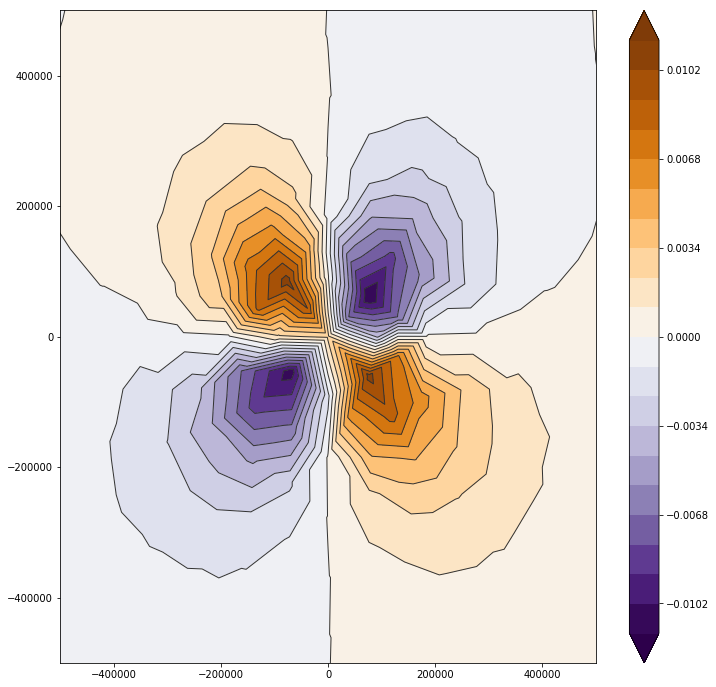

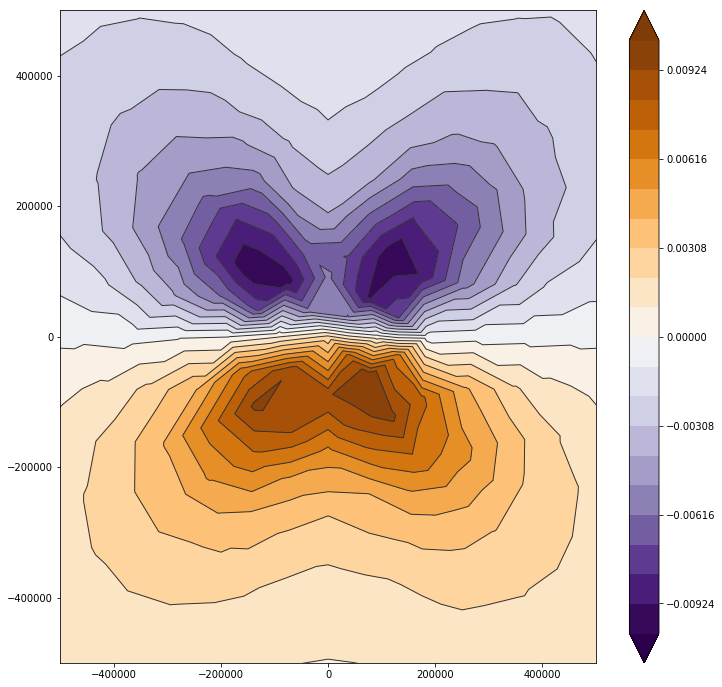

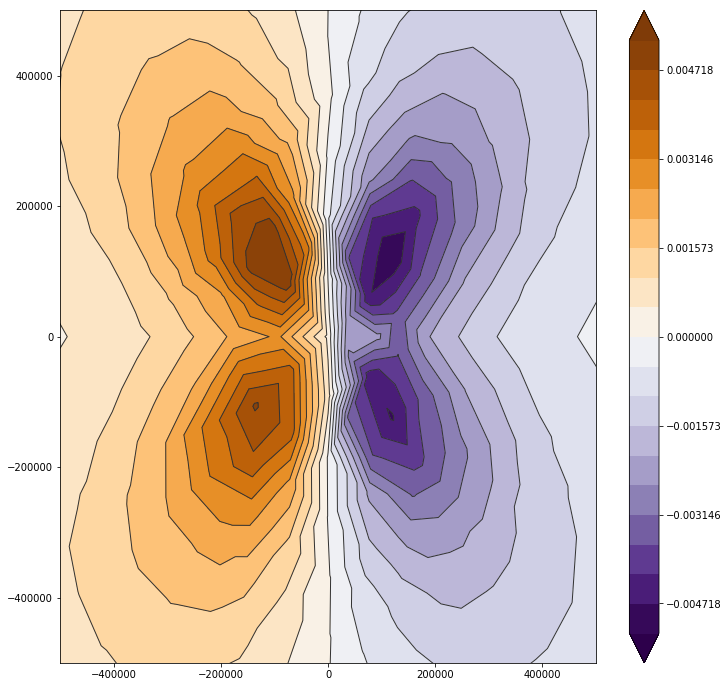

In [8]:
%matplotlib inline
front = surf_pts[:,0] >= 0
back = surf_pts[:,0] <= 0

# for d in range(3):
#     field = surf_disp[front,d]
#     vmin = np.min(field)
#     vmax = -vmin
#     W = 7000000
#     pretty_surf_plot(field, vmin, vmax, W, front)

for d in range(3):
    field = surf_disp[front,d]
    vmin = np.min(field)
    vmax = -vmin
    W = 500000
    pretty_surf_plot(field, vmin, vmax, W, front)
    
# for side in [front, back]:
#     field = np.log10(np.abs(surf_disp[side,1]))
#     vmin = np.min(field)
#     vmax = np.max(field)
#     W = 7000000
#     pretty_surf_plot(field, vmin, vmax, W, side)